In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train = nlp.load_dataset("json",data_files='/content/drive/MyDrive/code/Tweet-Emotion-Recognition/train.jsonl')['train']
val = nlp.load_dataset("json",data_files='/content/drive/MyDrive/code/Tweet-Emotion-Recognition/validation.jsonl')['train']
test = nlp.load_dataset("json",data_files='/content/drive/MyDrive/code/Tweet-Emotion-Recognition/test.jsonl')['train']

In [ ]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

tokenize

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

distribution of tweet lengths

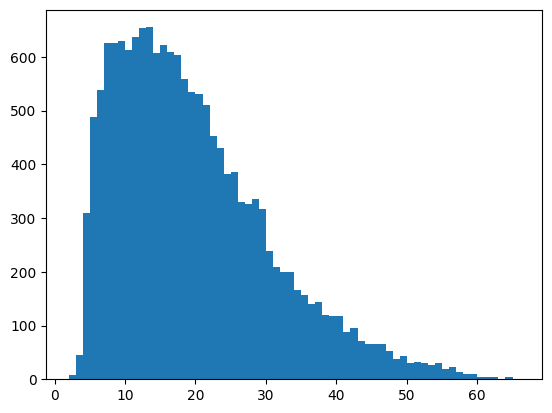

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt. hist(lengths, bins = len(set(lengths)))
plt.show ()

pad/truncate sequences

In [ ]:
maxlen = 50

In [ ]:
def get_sequences(tokenizer, tweets) :
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

prepare labels

In [ ]:
classes = set(labels)
print (classes)

{0, 1, 2, 3, 4, 5}


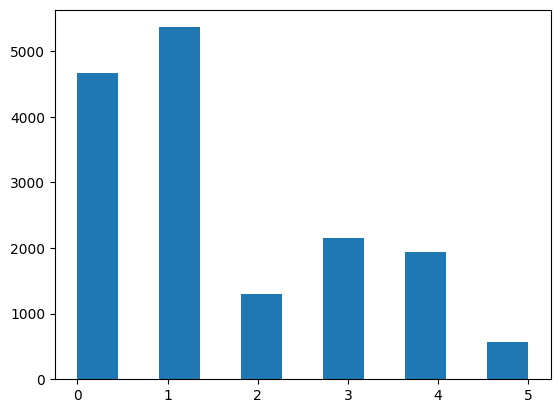

In [ ]:
plt.hist(labels, bins=11)
plt.show ()

In [ ]:
class_to_index = dict((c, i) for i, c in enumerate (classes))
index_to_class = dict((v, k) for k, v in class_to_index.items ())

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)

create model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding (10000, 16, input_length=maxlen),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
  tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_8 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


train model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels [0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
padded_train_seq.shape

(16000, 50)

In [ ]:
train_labels.shape

(16000,)

In [ ]:
h = model.fit(
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 67s 103ms/step - loss: 1.2917 - accuracy: 0.4948 - val_loss: 0.8417 - val_accuracy: 0.6985
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.5648 - accuracy: 0.8051 - val_loss: 0.4933 - val_accuracy: 0.8245
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2880 - accuracy: 0.9056 - val_loss: 0.3899 - val_accuracy: 0.8725
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1831 - accuracy: 0.9434 - val_loss: 0.3765 - val_accuracy: 0.8780
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1411 - accuracy: 0.9571 - val_loss: 0.3834 - val_accuracy: 0.8795
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1046 - accuracy: 0.9686 - val_loss: 0.4668 - val_accuracy: 0.8640
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0941 - accuracy: 0.9705 - val_loss: 0.3593 - val_accuracy: 0.89

evaluate model

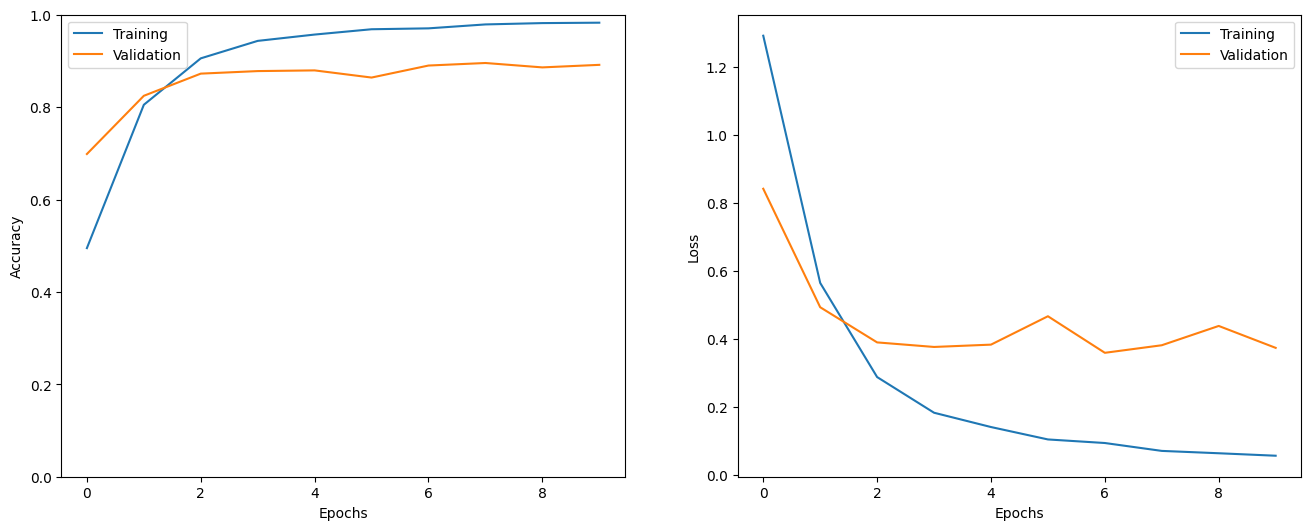

In [ ]:
epochs_trained = len(h.history['loss'])
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
plt.ylim([0., 1.])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences (tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4140 - accuracy: 0.8880


In [ ]:
i = random.randint(0, len(test_labels) - 1)

print ('Sentence:', test_tweets [i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class [np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i feel like ive come a long way and im proud of what ive achieved not only this week but this year as well
Emotion: 1
1/1 [==============================] - 1s 1s/step
Predicted Emotion: 1


In [ ]:
preds = model.predict(test_seq)

63/63 [==============================] - 0s 7ms/step


In [ ]:
preds=np.argmax(preds,axis=-1)

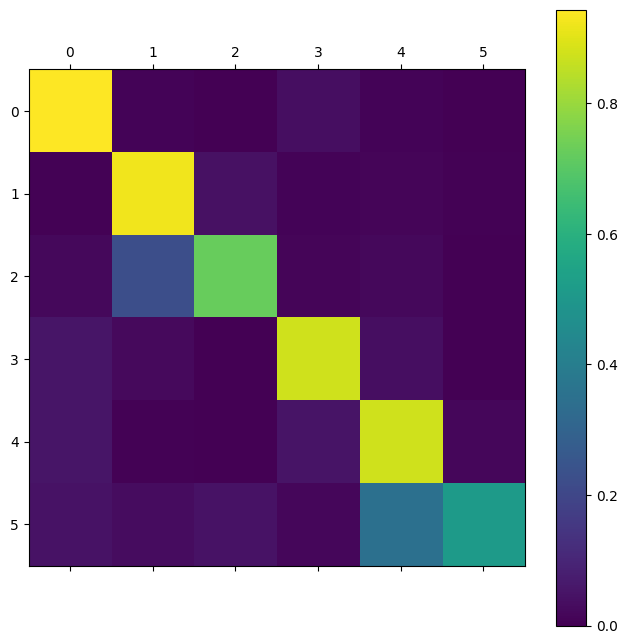

In [ ]:
cm = confusion_matrix(test_labels, preds, normalize='true')

plt.figure(figsize=(8, 8))
sp = plt.subplot(1, 1, 1)
ctx = sp.matshow(cm)
plt.xticks(list(range(0, 6)), labels=classes)
plt.yticks(list(range(0, 6)), labels=classes)
plt.colorbar(ctx)
plt.show()